#Quantum Neural Network (QNN) for Clasiifier:

In [17]:
pip install qiskit==0.46.1 qiskit-aer qiskit_machine_learning==0.7.2 pylatexenc


#1. load Dataset (Iris)

In [18]:
import pandas as pd  # Mengimpor pustaka pandas untuk manipulasi data

# Membaca file CSV
df = pd.read_csv('diabetess.csv')

# Menampilkan 10 baris pertama untuk memastikan kolom telah terhapus
df.head(10)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Outcome
0,6,148,72,35,1
1,1,85,66,29,0
2,8,183,64,0,1
3,1,89,66,23,0
4,0,137,40,35,1
5,5,116,74,0,0
6,3,78,50,32,1
7,10,115,0,0,0
8,2,197,70,45,1
9,8,125,96,0,1


In [19]:
import numpy as np

x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

indexes = np.array([i for i, s in enumerate(y) if s == 0 or s == 1])
x = x[indexes]

y = 2 * y[indexes] - 1


#2. Pre-Processing


In [20]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

x = MinMaxScaler().fit_transform(x)
# Menerapkan Min-Max Scaling pada data `x` sehingga semua nilai fitur berada di rentang [0, 1]


In [21]:
# Split train-test set (80:20)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



#3.QNN Model

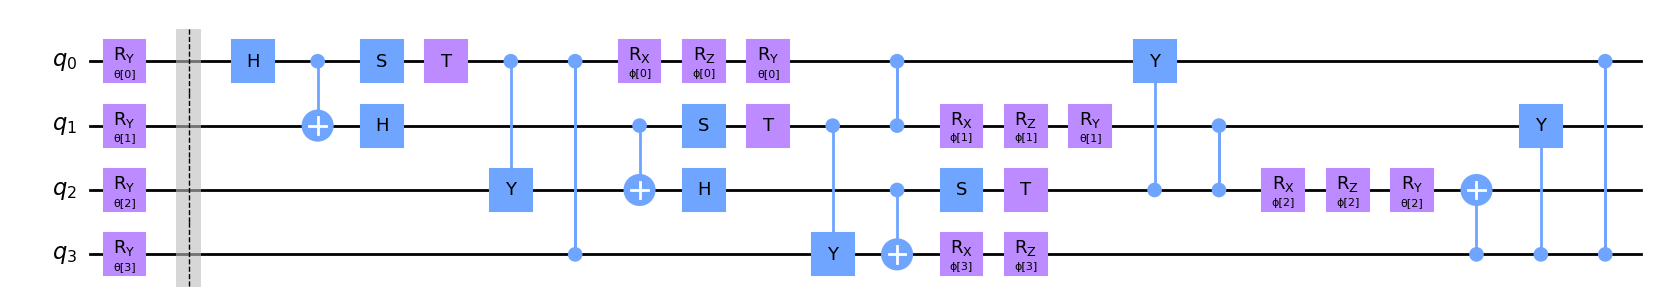

In [22]:
# Arsitektur sirkuit kuantum
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit import QuantumCircuit, ParameterVector

# Parameter sirkuit
num_qubits = x_train.shape[1]
theta = ParameterVector('θ', num_qubits)
phi = ParameterVector('ϕ', num_qubits)
circuit = QuantumCircuit(num_qubits)

# **Data Encoding**: Menggunakan rotasi RY untuk setiap qubit
for i in range(num_qubits):
    circuit.ry(theta[i], i)  # Menginisialisasi dengan rotasi Y
circuit.barrier()  # Menambahkan barrier untuk visualisasi yang lebih jelas

# **Ansatz**: Menambahkan berbagai gerbang untuk entanglement dan rotasi
for i in range(num_qubits - 1):
    # **Gerbang Hadamard (H)**
    circuit.h(i)  # Gerbang Hadamard pada qubit i

    # **Controlled-X (CX)**
    circuit.cx(i, i + 1)  # Controlled-X antara qubit i dan i+1

    # **Gerbang S dan T**
    circuit.s(i)  # Gerbang S pada qubit i
    circuit.t(i)  # Gerbang T pada qubit i

    # **Gerbang Controlled-Y (CY) dan Controlled-Z (CZ)**
    circuit.cy(i, (i + 2) % num_qubits)  # Controlled-Y antara qubit i dan qubit (i+2) mod num_qubits
    circuit.cz(i, (i + 3) % num_qubits)  # Controlled-Z antara qubit i dan qubit (i+3) mod num_qubits

    # Rotasi RX dan RZ untuk setiap qubit
    circuit.rx(phi[i], i)
    circuit.rz(phi[i], i)
    circuit.ry(theta[i], i)

# Qubit terakhir akan diberi rotasi tambahan (RX dan RZ)
circuit.rx(phi[num_qubits - 1], num_qubits - 1)
circuit.rz(phi[num_qubits - 1], num_qubits - 1)

# **Menambahkan entanglement lagi untuk qubit terakhir dengan qubit lainnya**
circuit.cx(num_qubits - 1, (num_qubits - 2) % num_qubits)
circuit.cy(num_qubits - 1, (num_qubits - 3) % num_qubits)
circuit.cz(num_qubits - 1, (num_qubits - 4) % num_qubits)

# Plot sirkuit
circuit.draw(output='mpl', style='clifford')



In [23]:
# Kurva pembelajaran
import time
from IPython.display import clear_output

objective_func_vals = []
# List untuk menyimpan nilai fungsi objektif selama proses pembelajaran

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.show()


In [24]:
# Classifier
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp, StateFn
from qiskit.algorithms.optimizers import COBYLA, ADAM, QNSPSA, AQGD
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

# Backend setup
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)

# Observable setup
observable = PauliSumOp.from_list([("XYZX", 1.0)])

# Optimizer setup
optimizer = COBYLA(maxiter=100)

# Quantum neural network (QNN) setup
qnn_expectation = StateFn(observable, is_measurement=True) @ StateFn(circuit)

estimator_qnn = EstimatorQNN(
    circuit=circuit,
    observables=observable,
    input_params=theta,
    weight_params=phi
)

# Neural network classifier setup
qnn = NeuralNetworkClassifier(
    estimator_qnn,
    optimizer=optimizer,
    loss='squared_error',
    callback=callback_graph
)


<ipython-input-24-79b994f0a69d>:12: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)
<ipython-input-24-79b994f0a69d>:21: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qnn_expectation = StateFn(observable, is_measurement=True) @ StateFn(circuit)
<ipython-input-24-79b994f0a69d>:21: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qnn_expectation = StateFn(observ

#4.Training

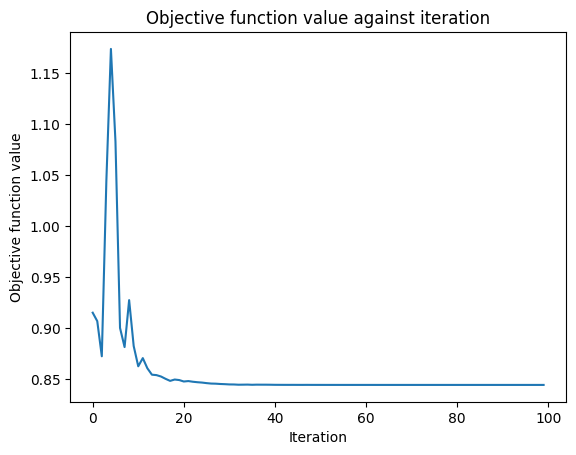

Training time: 0 seconds


In [25]:
qnn.fit(x_train, y_train) # Melatih jaringan neural kuantum (QNN) dengan data pelatihan (x_train, y_train)

start = time.time()
# Mencatat waktu mulai pelatihan
elapsed = time.time() - start
# Menghitung waktu yang berlalu selama pelatihan

print(f"Training time: {round(elapsed)} seconds")



In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import classification_report

y_pred_train = qnn.predict(x_train)
# Membuat prediksi pada data pelatihan
y_pred_test = qnn.predict(x_test)
# Membuat prediksi pada data pengujian

print('TRAINING:')
print(classification_report(y_train, y_pred_train))

print('TESTING:')
print(classification_report(y_test, y_pred_test))


TRAINING:
              precision    recall  f1-score   support

          -1       0.66      0.99      0.79       401
           1       0.64      0.03      0.06       213

    accuracy                           0.66       614
   macro avg       0.65      0.51      0.43       614
weighted avg       0.65      0.66      0.54       614

TESTING:
              precision    recall  f1-score   support

          -1       0.67      0.99      0.80        99
           1       0.86      0.11      0.19        55

    accuracy                           0.68       154
   macro avg       0.76      0.55      0.50       154
weighted avg       0.73      0.68      0.58       154



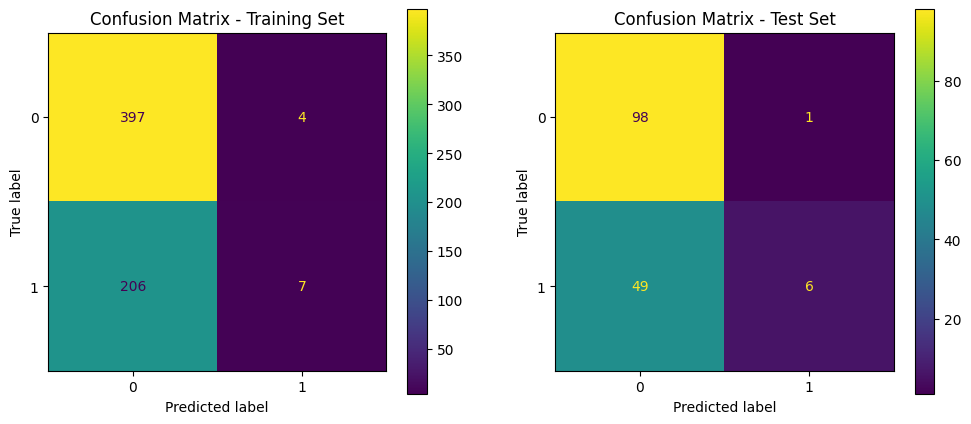

In [27]:
# Confusion matrix
cm_tr = confusion_matrix(y_train, y_pred_train)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
cm_ts = confusion_matrix(y_test, y_pred_test)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


disp_tr.plot(ax=ax[0])
# Menampilkan confusion matrix untuk data pelatihan pada subplot pertama
ax[0].set_title('Confusion Matrix - Training Set')

disp_ts.plot(ax=ax[1])
# Menampilkan confusion matrix untuk data pengujian pada subplot kedua
ax[1].set_title('Confusion Matrix - Test Set')


plt.show()

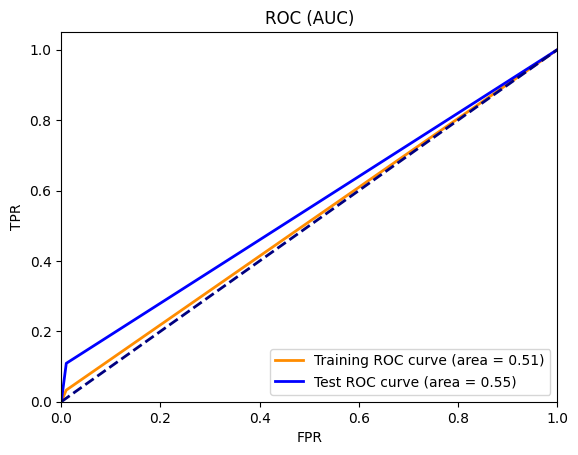

In [28]:
# Kurva ROC (AUC)
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_train)
roc_auc_tr = auc(fpr_tr, tpr_tr)

fpr_ts, tpr_ts, _ = roc_curve(y_test, y_pred_test)
roc_auc_ts = auc(fpr_ts, tpr_ts)

plt.figure()

# Plot ROC untuk data pelatihan
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2,
         label=f'Training ROC curve (area = {roc_auc_tr:.2f})')

# Plot ROC untuk data pengujian
plt.plot(fpr_ts, tpr_ts, color='blue', lw=2,
         label=f'Test ROC curve (area = {roc_auc_ts:.2f})')

# Garis diagonal sebagai baseline (ROC random)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Menentukan batas sumbu
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Menambahkan label dan judul
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC (AUC)')

plt.legend(loc="lower right")

# Menampilkan plot
plt.show()


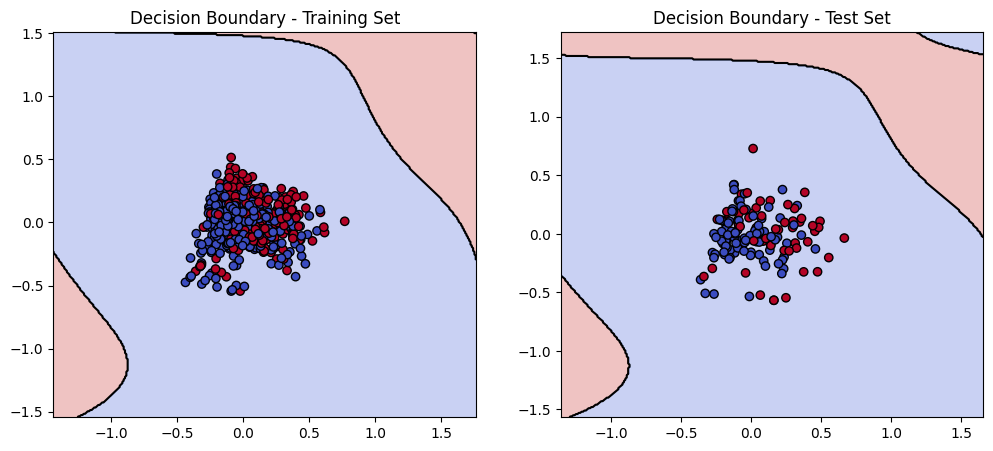

In [29]:
# Decision boundary
from sklearn.decomposition import PCA

def plot_decision_boundary(qnn, x, y, ax, title):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    mesh_points = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], 2))]
    Z = qnn.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=1.5)
    ax.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    ax.set_title(title)


pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(qnn, x_train_pca, y_train, ax[0], "Decision Boundary - Training Set")
plot_decision_boundary(qnn, x_test_pca, y_test, ax[1], "Decision Boundary - Test Set")
plt.show()
